<a href="https://colab.research.google.com/github/Afes4/Proyecto-IA/blob/main/Captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_folder = '/content/drive/MyDrive/Colab Notebooks/samples/samples/'

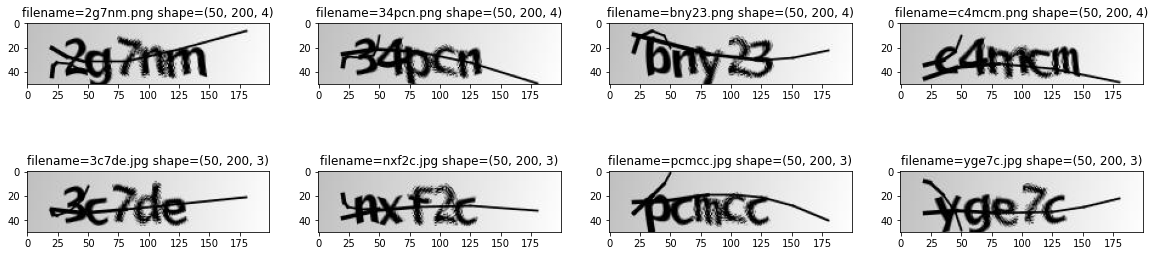

In [ ]:
img_2g7nm = mpimg.imread(img_folder + '2g7nm.png')
img_34pcn = mpimg.imread(img_folder + '34pcn.png')
img_bny23 = mpimg.imread(img_folder + 'bny23.png')
img_c4mcm = mpimg.imread(img_folder + 'c4mcm.png')
img_3c7de = mpimg.imread(img_folder + '3c7de.jpg')
img_nxf2c = mpimg.imread(img_folder + 'nxf2c.jpg')
img_pcmcc = mpimg.imread(img_folder + 'pcmcc.jpg')
img_yge7c = mpimg.imread(img_folder + 'yge7c.jpg')
samples = {'2g7nm.png':img_2g7nm, '34pcn.png':img_34pcn, 'bny23.png':img_bny23, 'c4mcm.png':img_c4mcm, 
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

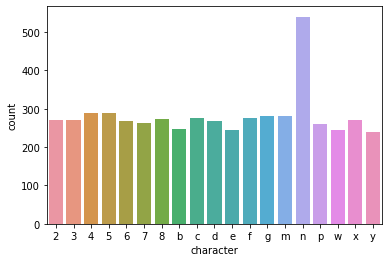

In [ ]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1
        
#df.head()

data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

In [ ]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

In [ ]:
# Dictionaries that will be used to convert characters to integers and vice-versa
vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

##############################################################################################################################
# This function encodes a single sample. 
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split X, y to get X_train, y_train, X_val, y_val 
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(936,200,50,1), X_val.reshape(104,200,50,1)
    return X_train, X_val, y_train, y_val

TypeError: ignored

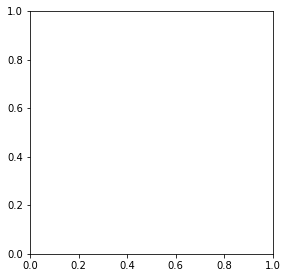

In [ ]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)

fig=plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[935], cmap='gray')
#plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[935]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
#plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_val[103], cmap='gray')
#plt.imshow(X_val[103].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[103]))
plt.axis('off')
fig.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(X_train_[935], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[935]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(X_val_[103], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[103]))
plt.axis('off')
plt.show()